In [371]:
# https://mapr.com/blog/deep-learning-tensorflow/
# TensorFlow_TimeSeries_RNN_MapR/RNN_Timeseries_Demo.ipynb at master · JustinBurg/TensorFlow_TimeSeries_RNN_MapR - https://github.com/JustinBurg/TensorFlow_TimeSeries_RNN_MapR/blob/master/RNN_Timeseries_Demo.ipynb

import numpy as np
import pandas as pd
import os


import matplotlib
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

matplotlib.style.use('ggplot')
%matplotlib inline
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

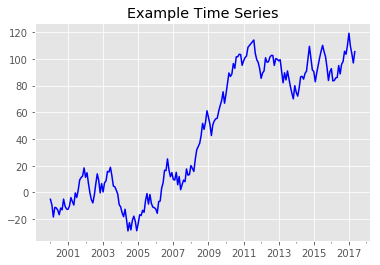

2000-01-31    -5.216416
2000-02-29    -9.351433
2000-03-31   -18.509721
2000-04-30   -11.221384
2000-05-31   -11.678753
2000-06-30   -13.266413
2000-07-31   -16.752767
2000-08-31   -11.756267
2000-09-30   -13.091033
2000-10-31    -5.063925
Freq: M, dtype: float64

In [330]:
#rng = pd.date_range(start='2000', periods=209, freq='M')
#ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
#ts.plot(c='b', title='Example Time Series')
#plt.show()
#ts.head(10)

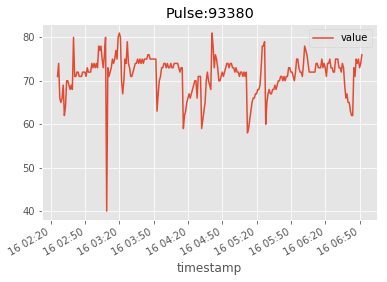

In [362]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
df = pd.read_csv('data/pulse_93380.txt',sep='\t',names=['value','timestamp'], parse_dates=['timestamp'], date_parser=dateparse)
#np.array(data[:5]['value'])
#np.array(data[:5]['timestamp'])
#serie = df.transpose()[0]
#serie
df.plot(x='timestamp',y='value',title='Pulse:93380')

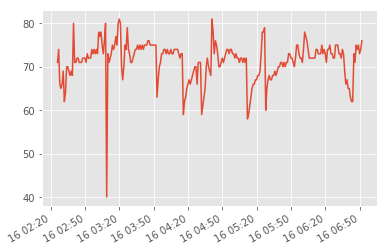

In [363]:
vals = np.array(df['value'])
stamps = np.array(df['timestamp'])
#ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
ts = pd.Series(vals,stamps)
#ts = ts.cumsum()

#ts
ts.plot()


In [373]:
num_periods = 20
f_horizon = 1
#rng = pd.date_range(start='2000', periods=209, freq='M')
#ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()


TS = np.array(ts)


b_max = len(TS)-(len(TS)%num_periods)
x_data = TS[:b_max]
x_batches = x_data.reshape(-1,20,1) #every 20
#print(len(x_batches))
#np.array([1,2,3,4,5,6]).reshape(3,2)
y_data = TS[1:b_max+f_horizon]
y_batches = y_data.reshape(-1,20,1) #every 20


#print (len(x_batches))
#print (x_batches.shape)
#print (x_batches[0:2])

#print (y_batches[0:1])
#print (y_batches.shape)


In [383]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods+forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,20,1)
    testY = TS[-(num_periods):].reshape(-1,20,1)
    return testX,testY
x_test,y_test = test_data(TS,f_horizon,num_periods)

In [388]:
input_num = 1
hidden = 100
output_num = 1
learning_rate = 0.001
epochs = 2000

tf.reset_default_graph()

# Create placeholder = variables
x = tf.placeholder(tf.float32,[None,num_periods,input_num])
y = tf.placeholder(tf.float32,[None,num_periods,output_num])

# RNN
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden,activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell,x,dtype=tf.float32)

# Output
stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])
statcked_outputs = tf.layers.dense(stacked_rnn_output,output_num)
outputs = tf.reshape(statcked_outputs,[-1,num_periods,output_num])

# Loss and Optimizer
loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Sessions
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()    
    for ep in range(epochs):
        sess.run(training_op,feed_dict={x:x_batches,y:y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={x:x_batches,y:y_batches})
            print(ep, 'MSE:', mse)
    y_pred = sess.run(outputs,feed_dict={x: x_test})
    print(y_pred)





0 MSE: 1189346.5
100 MSE: 31005.49
200 MSE: 9361.484
300 MSE: 3846.4968
400 MSE: 3441.0918
500 MSE: 3318.4512
600 MSE: 3239.8967
700 MSE: 3153.138
800 MSE: 3075.1833
900 MSE: 2990.846
1000 MSE: 2917.951
1100 MSE: 2818.1494
1200 MSE: 2697.1177
1300 MSE: 2532.4497
1400 MSE: 2434.8667
1500 MSE: 2333.427
1600 MSE: 2307.483
1700 MSE: 2225.505
1800 MSE: 2174.8704
1900 MSE: 2124.4414
[[[73.58833 ]
  [70.700584]
  [71.03928 ]
  [73.172485]
  [72.92508 ]
  [67.39773 ]
  [66.382904]
  [67.984116]
  [66.74708 ]
  [66.81758 ]
  [63.572105]
  [62.833073]
  [63.785725]
  [73.34686 ]
  [71.4244  ]
  [74.06213 ]
  [75.796814]
  [73.63984 ]
  [78.18812 ]
  [70.384926]]]


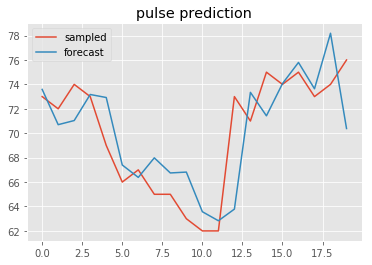

In [389]:

plt.title('pulse prediction')

plt.plot(pd.Series(np.ravel(Y_test)),label='sampled')
plt.plot(pd.Series(np.ravel(y_pred)),label='forecast')
plt.legend(loc="upper left")
plt.show()
